<a href="https://colab.research.google.com/github/kmjohnson3/ML4MI_Bootcamp_Development/blob/master/ImageReconstruction/CoLab_AutoMap_Recon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an MRI based reconstruction demo, for 2D MRI data. The network is relatively similar to the recent AutoMap technique (https://arxiv.org/abs/1704.08841). This is a relatively 'brute force' aproach to image reconstruction in which the transoform is given no direct knowledge of the physics (although the network architecture is a bit tuned to the problem). In this work, we are assuming one direction is fully sampled (i.e. frequency encoded).

# MRI Sampling
In MRI the data is often discretely Fourier transoformed in one direction leading to the discretized signal model:

$s(k)=\sum_{j=1}^{N}\rho (x_j)e^{i2\pi kx}$

The expected reconstruction for fully sampled data is an inverse discrete Fourier transform:

$s(x)=\sum_{j=1}^{N}s(k_j)e^{i2\pi k_j x}$

# Questions to think about:
1) What is the minimal network architecture to compute a DFT?

2) What is the apropriate loss function?

3) What is the role of the convolutional layers? When are they needed?

4) What is the network learning if you train on natural images?


In [0]:
''' 
In python you need to import libraries in order to use them. 
'''

# Import tensorflow ( we will use keras from tensorflow)
import tensorflow as tf

# Load Keras
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten
from tensorflow.keras.models import Model

# Utilities
import numpy as np
import math 

# Plotting
import matplotlib.pyplot as plt
from IPython.display import clear_output


# Training Images
We are training this network using a simulation enviroment. Images are grabbed from a set of MRI brain images. We then simulate the image to MRI raw data conversion. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!echo "Copying Data Locally (Image Synthesis)"
!tar xf "/content/drive/My Drive/ML4MI_BOOTCAMP_DATA/ImageSynthesis.tar" --directory /home/
!cp "/content/drive/My Drive/ML4MI_BOOTCAMP_DATA/Example_MRI_Data.h5" /home/

Copying Data Locally (Image Synthesis)


In [4]:
#Subsample to reduce memory and computational burden
subsample = 2

# load training, validation, and testing data
# adding a singleton dimension
import h5py
with h5py.File('/home/ImageSynthesis/data/ImageTranslationData.hdf5','r') as hf:
    
    # Stack the data from two constrasts
    x_train = np.array(hf['trainX'])[:,::subsample,::subsample]
    x_train = np.concatenate((x_train,np.array(hf['trainY'])[:,::subsample,::subsample]),axis=0)
    
    # Stack the data from two constrasts (validate)
    x_val = np.array(hf['valX'])[:,::subsample,::subsample]
    x_val = np.concatenate((x_val,np.array(hf['valX'])[:,::subsample,::subsample]),axis=0)

# Input images are Dicoms which are magnitude, add 2nd channel of zeros
x_train = np.stack((x_train,np.zeros(x_train.shape,dtype=x_train.dtype)), -1)
x_val = np.stack((x_val,np.zeros(x_val.shape,dtype=x_train.dtype)), -1)

print(f'Validate Dataset Size {x_val.shape}')
print(f'Train Dataset Size {x_train.shape}')
N = x_train.shape[-2]

Validate Dataset Size (2138, 120, 120, 2)
Train Dataset Size (10830, 120, 120, 2)


In [0]:
# This is a montage maker along 1st dim
def montage( img_in, size=(3,5) ):
    for j in range(size[0]):
        plot_image = img_in[0+size[1]*j,:,:]
        for i in range(size[1]-1):
            plot_image = np.concatenate((plot_image, img_in[1+i+size[1]*j,:,:]), axis=1)
        
        if j == 0:
            img = plot_image
        else:
            img = np.concatenate((img,plot_image),axis=0)
    return img
  
def complex_to_channels( img_in):
  return(np.stack(img_in.real,img_in.imag))
  
def channels_to_complex( img_in):
  return(img_in[...,0]+1j*img_in[...,1])
  

# Simulate Sampling
MRI data generation is aproximately dsicrete sampling of a continous Fourier transform the the data. In this example, we are using a Discrete Fourier transform to aproximate this. We also consider the case when we randomly remove data points. This would allow us to go faster and is used in compressed sensing application ( e.g. https://onlinelibrary.wiley.com/doi/pdf/10.1002/mrm.21391 ). Noise is added a complex, white, gaussian noise (MRI noise is so called Johnson/Nyquist noise). Things to try:

1) Add higher levels of noise. What happens to the training rate and output images? 

2) Increase the undersampling rate. How does the neural network compare to traditional aproaches? 

3) Comment the FFT shift, does the network still learn the transform?

In [6]:
'''
The creates a sampling mask which can be used to subsample the data.
'''

# Get the number of phase encodes
undersample_factor = 1.0 
noise_level = 0.001; 

number_phase_encodes = int(N/undersample_factor)
print('Using ' + str(number_phase_encodes) + ' phase encode')

# Create a random mask to resample the data
idx = np.full(N, False)
idx[:number_phase_encodes] = True
np.random.shuffle(idx)
sampling_mask = idx

'''
Fourier transform in 3rd dimension (Ny) followed by an FFT shift 
'''
Nexamples = x_train.shape[0]
kspace_train = np.zeros((Nexamples,N,number_phase_encodes,2),x_train.dtype)
for example in range(x_train.shape[0]):
  
  if example % 1000 == 0:
    print(f'Working on example {example} of {Nexamples}')
      
  # Grab one image
  temp = x_train[example,:,:,0] + 1j*x_train[example,:,:,1]
  
  # Fourier Transform
  kspace_temp = np.fft.fftn(temp,axes=(1,))/N
  kspace_temp = np.fft.fftshift(kspace_temp,axes=(1,))
  kspace_temp =np.stack( (kspace_temp.real, kspace_temp.imag), axis=-1)
  
  # Subsample
  kspace_temp = kspace_temp[:,sampling_mask,:]
  
  # Add noise
  kspace_temp += noise_level*np.random.randn(*kspace_temp.shape)

  # Put back
  kspace_train[example,:,:,:] = kspace_temp
  
print('Dimensions of training data are ' + str(kspace_train.shape) + '[ Examples x Nx x Ny x Channels]')




'''
Fourier transform in 3rd dimension (Ny) followed by an FFT shift 
'''
Nexamples = x_val.shape[0]
kspace_val = np.zeros((Nexamples,N,number_phase_encodes,2),x_train.dtype)
for example in range(x_val.shape[0]):
  
  if example % 1000 == 0:
    print(f'Working on example {example} of {Nexamples}')
      
  # Grab one image
  temp = x_val[example,:,:,0] + 1j*x_val[example,:,:,1]
  
  # Fourier Transform
  kspace_temp = np.fft.fftn(temp,axes=(1,))/N
  kspace_temp = np.fft.fftshift(kspace_temp,axes=(1,))
  kspace_temp =np.stack( (kspace_temp.real, kspace_temp.imag), axis=-1)
  
  # Subsample
  kspace_temp = kspace_temp[:,sampling_mask,:]
  
  # Add noise
  kspace_temp += noise_level*np.random.randn(*kspace_temp.shape)

  # Put back
  kspace_val[example,:,:,:] = kspace_temp
  
print('Dimensions of training data are ' + str(kspace_val.shape) + '[ Examples x Nx x Ny x Channels]')
  

Using 120 phase encode
Working on example 0 of 10830
Working on example 1000 of 10830
Working on example 2000 of 10830
Working on example 3000 of 10830
Working on example 4000 of 10830
Working on example 5000 of 10830
Working on example 6000 of 10830
Working on example 7000 of 10830
Working on example 8000 of 10830
Working on example 9000 of 10830
Working on example 10000 of 10830
Dimensions of training data are (10830, 120, 120, 2)[ Examples x Nx x Ny x Channels]
Working on example 0 of 2138
Working on example 1000 of 2138
Working on example 2000 of 2138
Dimensions of training data are (2138, 120, 120, 2)[ Examples x Nx x Ny x Channels]


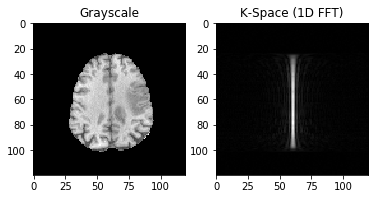

In [7]:
example = 400

# Show one image and k-space pair(should be whale)
img = x_train[example,:,:,0] + 1j*x_train[example,:,:,1]

plt.figure()
plt.subplot(121)
plt.imshow(np.abs(img),cmap='gray')
plt.title('Grayscale')

img = kspace_train[example,:,:,0] + 1j*kspace_train[example,:,:,1]

plt.subplot(122)
plt.imshow(np.abs(img),cmap='gray')
plt.title('K-Space (1D FFT)')
plt.show()

# Build the network architecture

In [10]:
# Build functional model
inputs = Input(shape=(N,number_phase_encodes,2), dtype='float32')
x = keras.layers.Conv2D(2*N,kernel_size=(1,number_phase_encodes),padding='valid',activation='linear', use_bias=False)(inputs)
x = keras.layers.Permute((1,3,2))(x)
x = keras.layers.Conv2D(2*N,kernel_size=(1,2*N),activation='linear',padding='valid',use_bias=False)(x)
x = keras.layers.Reshape((N,N,2))(x)


x = keras.layers.Conv2D(8,kernel_size=(3,3),activation='relu',padding='same',use_bias=True)(x)
x = keras.layers.Conv2D(8,kernel_size=(3,3),activation='relu',padding='same',use_bias=True)(x)
x = keras.layers. Conv2D(2,kernel_size=(3,3),activation='relu',padding='same',name='out_image',use_bias=True)(x)

# Recon Network
model = Model(inputs=inputs,outputs=x)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='mean_squared_error')

# Print a summary
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 120, 2)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 1, 240)       57600     
_________________________________________________________________
permute_2 (Permute)          (None, 120, 240, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 1, 240)       57600     
_________________________________________________________________
reshape_2 (Reshape)          (None, 120, 120, 2)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 120, 8)       152       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 120, 8)       584 

# Build a callback

In [0]:
'''
    This is a traing callback that the fitting algorithm will run during training
'''
class TraingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(10,3))
        self.logs = []
        self.floor_epoch = 0
        self.batch_size = batch_size
    
    #def on_train_end( self, logs={}):
        # Do nothing
        
    #def on_batch_begin(self, batch, logs={}): 
        # Do nothing 
        
    def on_batch_end(self, batch, logs={}):
        
        if batch%1000==0:
            self.losses.append(logs.get('loss'))
            
            clear_output(wait=True)
            self.fig = plt.figure(figsize=(10,3))
            
                
            # self.params
            #{'verbose': 1, 'nb_epoch': 12, 'batch_size': 128, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'], 'nb_sample': 60000, 'do_validation': True}
            batch_size = self.params['batch_size']
            
            example = np.random.randint(10000)
            example = 400 
        
            '''
                Run a test case
            '''        
            # Test with above image
            kspace1image = kspace_val[example,:,:,:]
            kspace1image = np.expand_dims(kspace1image,0)
            act_image = x_val[example,:,:,:]
            predicted_image = np.squeeze(model.predict(x=kspace1image))
                        
            act_image = act_image[:,:,0] + 1j*act_image[:,:,1]
            predicted_image = predicted_image[:,:,0] + 1j*predicted_image[:,:,1]
            
            plt.subplot(132)
            plt.imshow(np.abs(predicted_image), cmap='gray',vmin=0,vmax=1)
            plt.title('Predicted Image')
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(np.abs(act_image),cmap='gray',vmin=0,vmax=1)
            plt.title('True Image')
            plt.axis('off')
            
            # Using just this one image to get a loss
            temp = x_val[example,:,:,:]
            temp = np.expand_dims(temp,0)
            self.val_losses.append( model.evaluate(x=kspace1image,y=temp,verbose=False))
            
            '''
            Plot the Losses 
            '''
            plt.subplot(131)
            plt.semilogy(self.losses, label="Loss")
            plt.semilogy(self.val_losses, label="Loss (test image)")
            plt.legend()
            
            print('Epoch = ' + str(self.floor_epoch) + 'Loss = ' + str(logs.get('loss')) )
            plt.show();
            
    def on_epoch_begin(self,epoch,logs={}):
        self.floor_epoch = epoch
            
    #def on_epoch_end(self,epoch,logs={}):

# Run the model fit

Epoch = 3Loss = 9.626207e-06


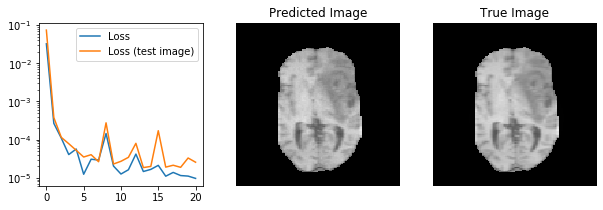

KeyboardInterrupt: ignored

In [12]:
batch_size  = 2

# Create the callback object 
training_callback = TraingCallback()

# Run model fit
hist = model.fit(x=kspace_train, # Input to NN
                 y=x_train, # Expected output
                 batch_size=batch_size, # Minibatch size
                 epochs=10, # Times to raster through data
                 callbacks=[training_callback],  # Run this function during training
                 shuffle=True,
                 verbose=False
                );

model.save("TrainedModel.h5")


1/1 [==============================] - 0s 2ms/sample - loss: 2.4065e-05


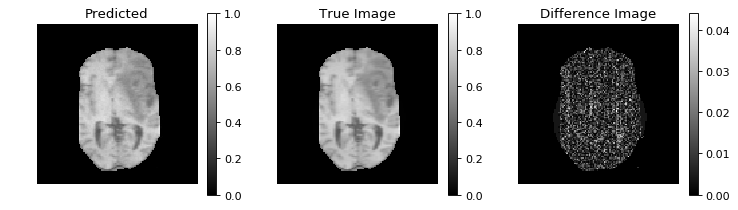

In [13]:
example = 400

# Test with synthetic data
kspace = kspace_val[example,...]
kspace = np.expand_dims(kspace,0)

image = x_val[example,...]
image = np.expand_dims(image,0)


predicted_image = np.squeeze(model.predict(x=kspace))
error = model.evaluate(kspace,image)

# Convert to complex
predicted_image = channels_to_complex(predicted_image)
act_image = channels_to_complex(x_val[example,...])


# Plot
plt.figure(figsize=(11, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.imshow(np.abs(predicted_image),cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('Predicted')

plt.subplot(132)
plt.imshow(np.abs(act_image),cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('True Image')

plt.subplot(133)
plt.imshow(np.abs(act_image-predicted_image),cmap='gray',vmin=0)
plt.axis('off')
plt.colorbar()
plt.title('Difference Image')

plt.show()

# Compare to least squares solution with data
Here we compare to an alterantive aproach, regularied least squares. In this technique, we build an encoding matrix which simulates the data acquisition. Then we minimize:

$\parallel Ex-d \parallel_2 +  \lambda \parallel x \parallel_2$

Where $\lambda$ is a factor that regularizes the solution when its illposed ( see https://en.wikipedia.org/wiki/Tikhonov_regularization ). The solution to this set of equations is:

$ \widetilde{x} = (E^hE + \lambda I)^{-1}E^hd$

Where I is an identity matrix. Similar to the neural network this is an aproximate solution.

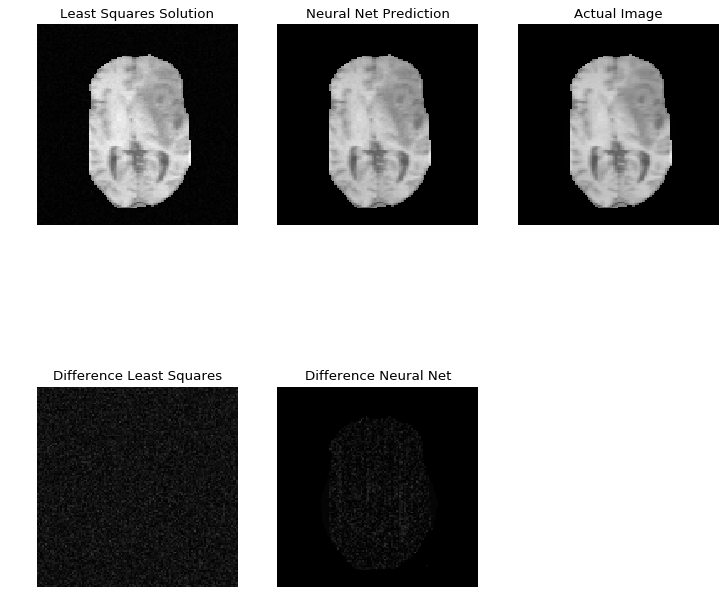

Image Domain Mean Squared Error NN = 0.69306767
Image Domain Mean Squared Error LS = 3.4133847035734544
Kspace Mean Squared Error NN = 10.258752102808879
Kspace Mean Squared Error LS = 10.257473890327656


In [14]:
# Lets also solve this a different way using a matrix inverse
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( 2 * math.pi * 1J / N )
    W = np.power( omega, i * j ) / N #math.sqrt(N)
    return W

E = DFT_matrix(N)
E = np.fft.fftshift(E,axes=(0,))
E = E[idx,:]

# Grab the data
D = np.matrix.getH(channels_to_complex(kspace_val[400,...]))

# Solve for psuedo inverse
Eh = np.matrix.getH(E)
EhE = np.matmul(Eh,E)
Ei = np.linalg.inv(EhE + 0.00001*np.identity(N))
EiEh = np.matmul(Ei,Eh)

linear_algebra_prediction = np.transpose(np.matmul(EiEh,D))
    
plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(231)
plt.imshow(np.abs(linear_algebra_prediction),cmap='gray',vmin=0)
plt.axis('off')
plt.title('Least Squares Solution')
plt.subplot(234)
plt.imshow(np.abs(linear_algebra_prediction-act_image),cmap='gray',vmin=0,vmax=0.2)
plt.axis('off')
plt.title('Difference Least Squares')

plt.subplot(232)
plt.imshow(np.abs(predicted_image),cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.title('Neural Net Prediction')
plt.subplot(235)
plt.imshow(np.abs(predicted_image-act_image),cmap='gray',vmin=0,vmax=0.2)
plt.axis('off')
plt.title('Difference Neural Net')

plt.subplot(233)
plt.imshow(np.abs(act_image),cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.title('Actual Image')

plt.show()

print('Image Domain Mean Squared Error NN = ' + str(np.sum(np.square(abs(np.squeeze(predicted_image) - act_image)))) )
print('Image Domain Mean Squared Error LS = ' + str(np.sum(np.square(abs(linear_algebra_prediction - act_image)))) )

# Lets also get the kspace error
kspace_NN = np.matmul(E,np.squeeze(predicted_image))
kspace_LA = np.matmul(E,linear_algebra_prediction)

# Difference 
diff_kspace_NN = kspace_NN - D
diff_kspace_LA = kspace_LA - D
print('Kspace Mean Squared Error NN = ' + str(np.sum(np.square(abs(diff_kspace_NN)))) )
print('Kspace Mean Squared Error LS = ' + str(np.sum(np.square(abs(diff_kspace_LA)))) )

# Load real MRI data to test
This is actual acquired MRI data from a 48 channel brain scan consisting of 15 slices. The data size is exactly the same width as the cifar100 images we used for training. Just to make things doable in a short time we are keeping everything 1D, as above.  

In [15]:
# Load a Kspace dataset from an actual acquisition
with h5py.File('/home/Example_MRI_Data.h5','r') as hf:
    kspace_mri = np.array(hf['Kspace'])

#Crop Kspace
crop = ( kspace_mri.shape[-2] - N ) // 2
kspace_mri = kspace_mri[...,::subsample,crop:-crop]
    
print(f'Kspace size = {kspace_mri.shape} [ channels, slices, Nx, Ny], type = {kspace_mri.dtype}')
coils = kspace_mri.shape[0]
slices = kspace_mri.shape[1]


Kspace size = (8, 48, 120, 120) [ channels, slices, Nx, Ny], type = complex64


# Run a traditional reconstruction 
The most common reconstruction on MRI scanners is to just do a discrete Fourier transform of the data. Just a note, the data actually has 48 recievers of the signal. We are taking the sum of sqyares to average these signals.

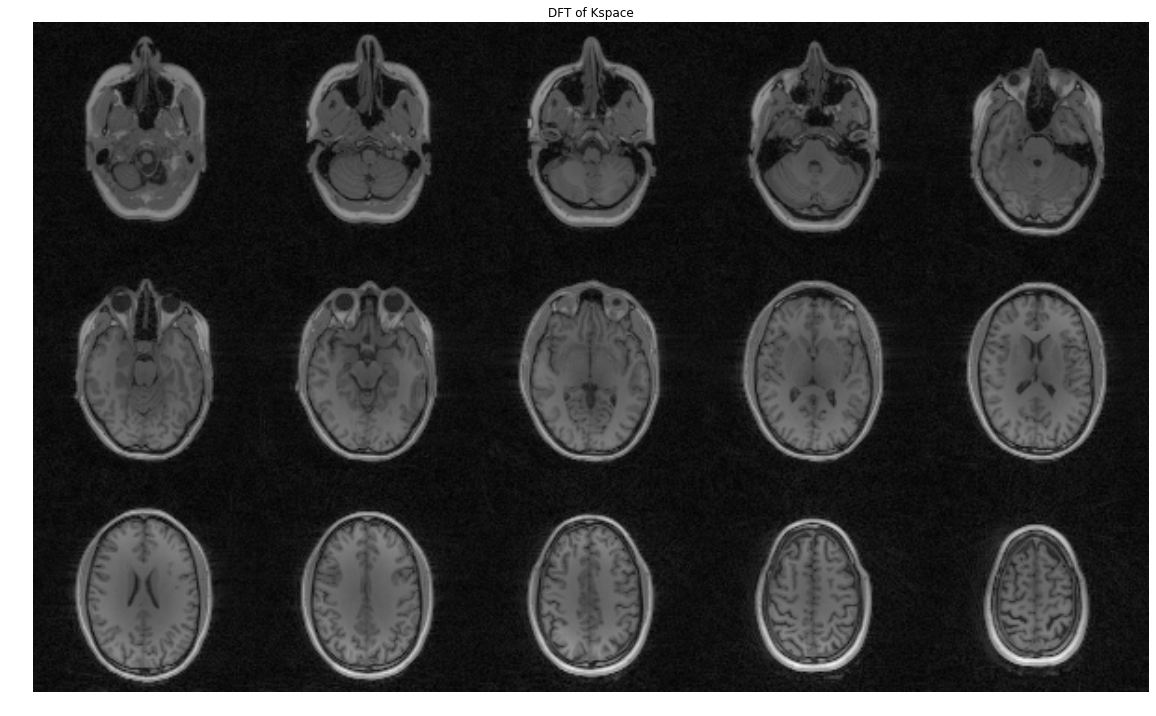

In [16]:
# Traditional recon of fully sampled data
image_full = np.fft.ifftn(kspace_mri,axes=(-1,))

# do sum of squares to average coils (detectors)
image_full = np.sum(abs(image_full),axis=0)
image_full = np.sqrt(image_full)

# Make a montage (there are other options)
plot_image = montage(image_full[8::2,:,:])  
    
# Show the image
plt.figure(figsize=(20,20))
plt.imshow(plot_image,aspect=1,interpolation='bilinear',cmap='gray')
plt.axis('off')
plt.title('DFT of Kspace')
plt.show()

# Do inference on the real MRI data

(384, 120, 120, 2)
(384, 120, 120, 2)


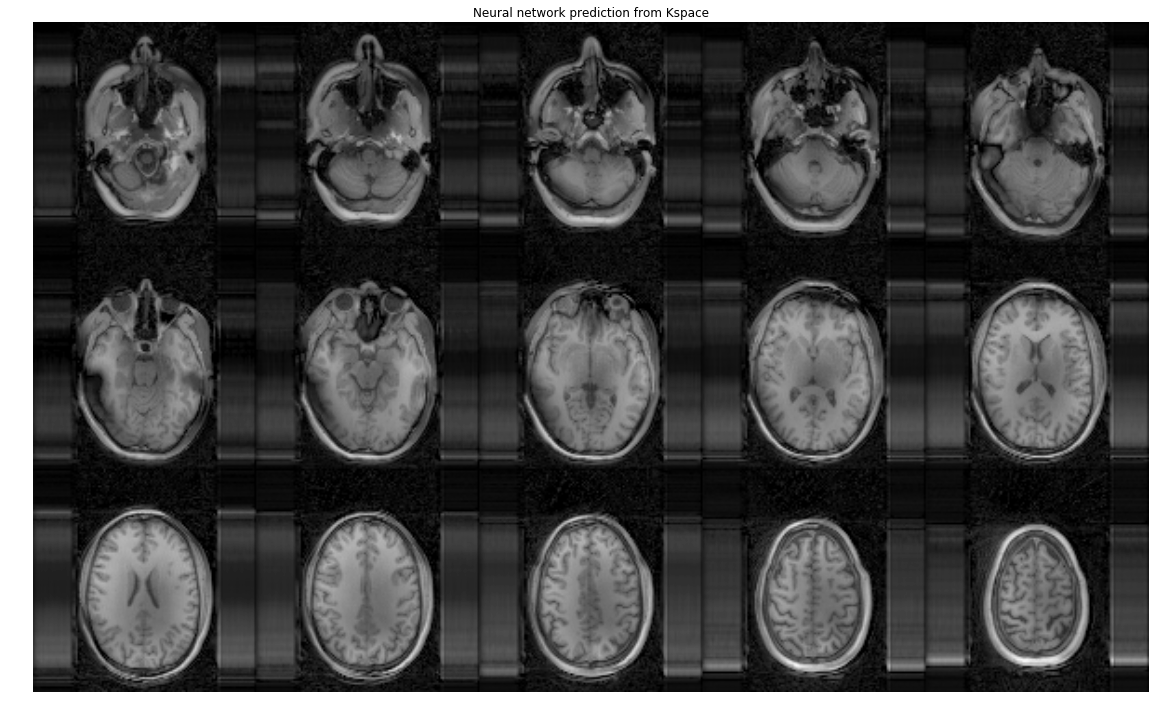

In [17]:
# Subsample kspace and convert to channels
kspace_mri2 = kspace_mri[:,:,:,sampling_mask]
kspace_mri2 = np.stack((kspace_mri2.real,kspace_mri2.imag),axis=-1)


kspace_mri2 = np.reshape(kspace_mri2,(-1,N,number_phase_encodes,2))
print(kspace_mri2.shape)

# Run model
image_NN = model.predict(x=kspace_mri2)
print(image_NN.shape)


# Reshape
image_NN = np.reshape( image_NN,(coils,slices,N,N,2))
image_NN = channels_to_complex(image_NN)

# do sum of squares to average coils (detectors)
image_NN = np.sum(abs(image_NN),axis=0)
image_NN = np.sqrt(image_NN)

# Make a montage (there are other options)
plot_image = montage( image_NN[8::2,:,:])

# Show the image
plt.figure(figsize=(20,20))
plt.imshow(plot_image,aspect=1,interpolation='bilinear',cmap='gray')
plt.axis('off')
plt.title('Neural network prediction from Kspace')
plt.show()

(46080, 120, 1)


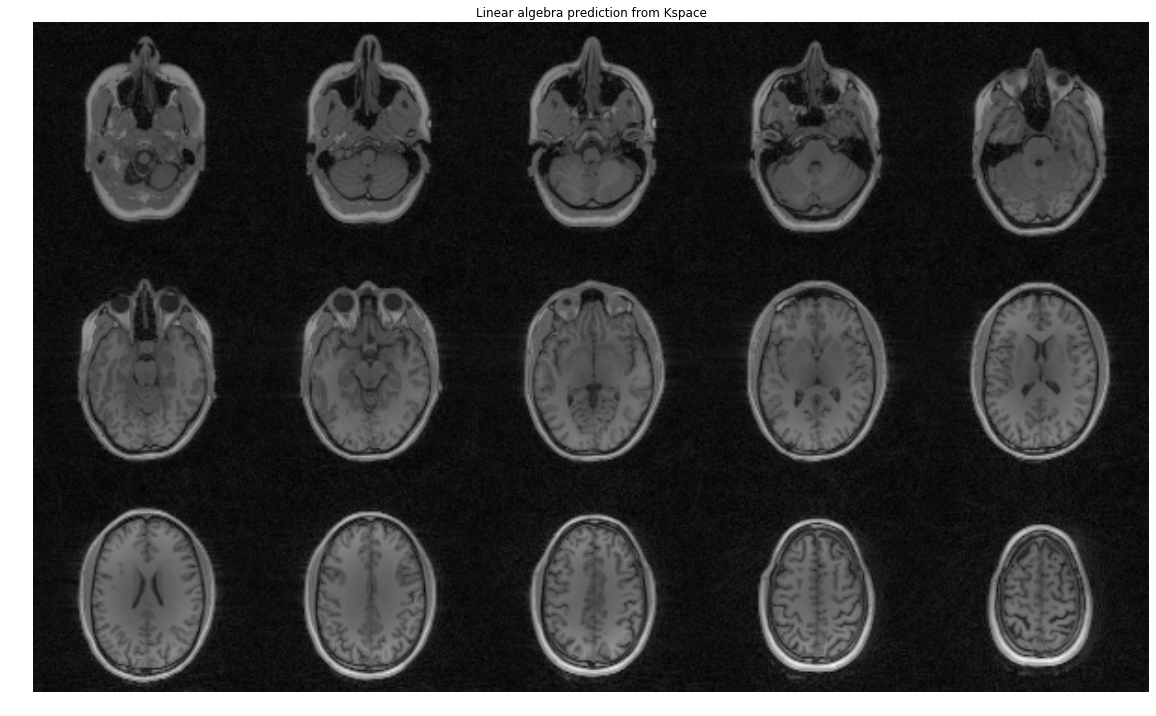

In [18]:
# Subsample kspace and convert to channels
kspace_mri2 = kspace_mri[:,:,:,sampling_mask]
kspace_mri2 = np.reshape(kspace_mri2,(-1,number_phase_encodes))
kspace_mri2 = np.expand_dims(kspace_mri2,-1)
print(kspace_mri2.shape)

# Also do for Least squares estimate
image_LA = np.matmul(EiEh,kspace_mri2)
image_LA = np.reshape(image_LA,(coils,slices,N,N))

# do sum of squares to average coils (detectors)
image_LA = np.sum(abs(image_LA),axis=0)
image_LA = np.sqrt(image_LA)

# Make a montage (there are other options)
plot_image = montage( image_LA[8::2,:,:])

# Show the image
plt.figure(figsize=(20,20))
plt.imshow(plot_image,aspect=1,interpolation='bilinear',cmap='gray')
plt.axis('off')
plt.title('Linear algebra prediction from Kspace')
plt.show()

# Now compare the solutions

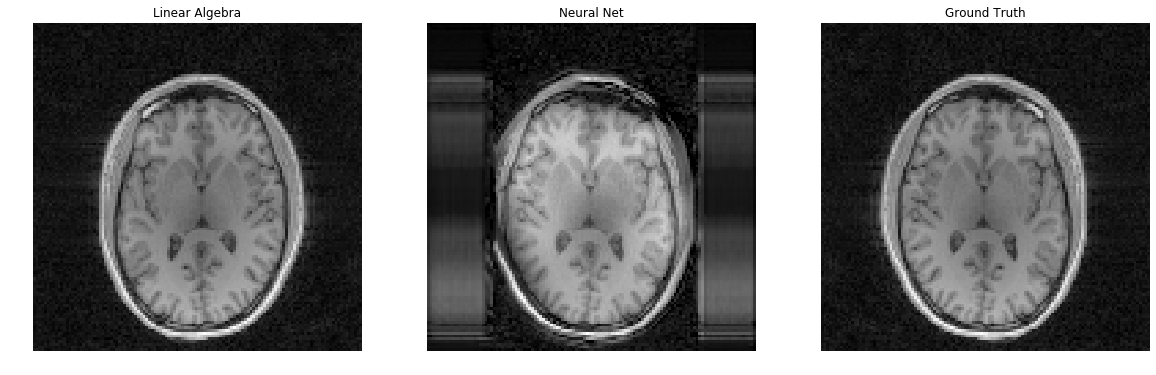

In [20]:
slice = 24

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(abs(image_LA[slice,:,:]),cmap='gray')
plt.axis('off')
plt.title('Linear Algebra')

plt.subplot(132)
plt.imshow(abs(image_NN[slice,:,:]),cmap='gray')
plt.axis('off')
plt.title('Neural Net')

plt.subplot(133)
plt.imshow(abs(image_full[slice,:,:]),cmap='gray')
plt.axis('off')
plt.title('Ground Truth')

plt.show()